In [1]:
import numpy as np
import pandas as pd
import re, os, path, csv
import glob

import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
# import larch
# from larch import xafs
sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')
sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\Xray-project\Dynamic XAS')


from numpy import fft
from frxas import time_domain, models, hdf5_io
import D_XAS_Function_Definitions as D_XAS
%reload_ext autoreload
%autoreload 2

In [2]:
def sort_func(all_files):
    return int(all_files.split('\\E')[-1].split('_E')[0])

def colorfun(V,Max=1):
#     print(V, Max)
    if V>0:
        R=V/Max
        G=0
        B=0
    else:
        R=0
        G=0
        B=-V/Max
    return (R,G,B)

In [3]:
direc = r'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\Energy Spectrum_0.5Hz\\'
match_str = 'E*_EtaAlign_Ir.h5'
match_str_eta = 'E*_EtaAlign_Eta.h5'
all_files = glob.glob(os.path.join(direc,match_str))
all_files.sort(key=sort_func)

all_files_eta = glob.glob(os.path.join(direc,match_str_eta))
all_files_eta.sort(key=sort_func)

In [4]:
models_Ir, models_Eta = [], []
for file, file_eta in zip(all_files, all_files_eta):
    models_Ir.append(hdf5_io.load_time_domain_fit(file[:-3]))
    models_Eta.append(hdf5_io.load_time_domain_fit(file_eta[:-3]))
meta = np.genfromtxt('..\\Feb2018 Data Fits\\Energy Spectrum_0.5Hz\\Energies_Iravgs.csv', delimiter=',',skip_header=1)
energies = meta[:,1]
Ir_avgs = meta[:,2]

In [5]:
models_Eta[0]

In [6]:
Irs, Etas, Vs, Ir_actual = [], [], [], []
for model_Ir, model_Eta, Ir_avg in zip(models_Ir, models_Eta, Ir_avgs):
    Ns = int(model_Ir.ndata/2)
    dt = 1/(model_Ir.userkws['frequencies'][0]*-2)
    freq_in = model_Ir.userkws['freq_in']
    b = model_Ir.userkws['window_param']
    ti = np.linspace(0, dt*(Ns-1),num=Ns)
    Ns_wfm = int(1/freq_in/dt)
    Ir = fft.ifft(fft.ifftshift(model_Ir.eval()*(Ns*np.pi)))
    Eta = fft.ifft(fft.ifftshift(model_Eta.eval()*(Ns*np.pi)))
    window = time_domain.gauss_window(np.ones(Ns), freq_in, ti, b)
    ti = ti[:Ns_wfm]
    Irs.append(Ir[:Ns_wfm]/window[:Ns_wfm])
    Etas.append(Eta[:Ns_wfm]/window[:Ns_wfm])
    Ir_actual.append(Ir[:Ns_wfm]/window[:Ns_wfm] + Ir_avg)
Irs = np.array(Irs)
Etas = np.array(Etas)
Ir_actual = np.array(Ir_actual)

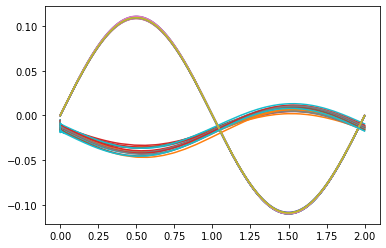

In [7]:
_, ax = plt.subplots()
maxes=[]
for (eta, Ir) in zip(Etas[70:90,:], Irs[70:90,:]):
    maxes.append(np.max(eta.real))
    ax.plot(ti, eta.real)
    ax.plot(ti, Ir.real)             

(2.3, 2.48)

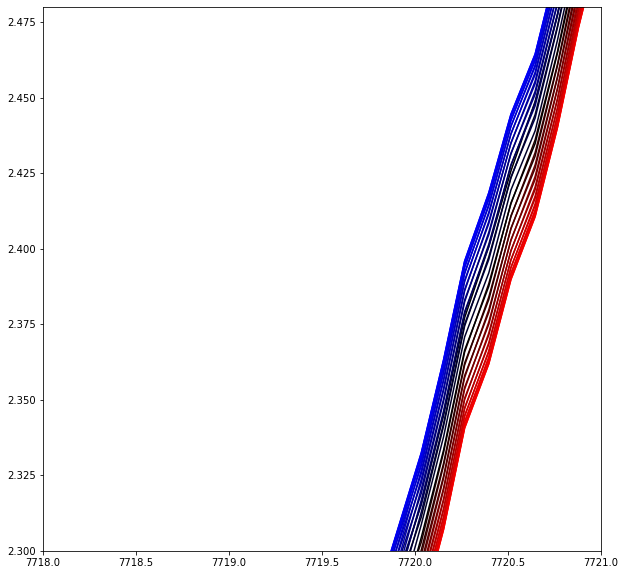

In [8]:
_, ax1 = plt.subplots( figsize=(10,10))

for i in range(0, 40):
    ax1.plot(energies, Ir_actual[:,i*50].real, color=colorfun(Etas[0,i*50].real,np.max(np.abs(Etas[0,:].real))))
ax1.set_xlim(7718, 7721)
ax1.set_ylim(2.3,2.48)

In [9]:
deglitch = [0,1,2,6,178,179]
energies[deglitch]
deglitch_mask = np.ones((len(energies)),dtype=bool)
deglitch_mask[:] = True
deglitch_mask[deglitch] = False

In [10]:
energies.shape

(180,)

In [11]:
Ir_actual[:,0].shape

(180,)

In [14]:
xafs.autobk(energy=energies, mu=Ir_actual[:,0].real)

AttributeError: 'NoneType' object has no attribute 'autobk_details'

In [13]:
direc = r'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\'
for i, (Ir,eta) in enumerate(zip(Ir_actual[deglitch_mask].T,Etas[0])):
#     print(np.shape(Ir[None].T), np.shape(energies[deglitch_mask,None]))
    svname = direc + f'{i} Eta {eta.real*1000:.2f} mV.txt'
    svdat = np.concatenate((energies[deglitch_mask, None], Ir[None].T.real), axis=1)
    print(svname, svdat.shape, i)
#     np.savetxt(svname, svdat, delimiter='\t', fmt='%.8e')

C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\0 Eta -0.09 mV.txt (174, 2) 0
C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\1 Eta 0.03 mV.txt (174, 2) 1
C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\2 Eta 0.35 mV.txt (174, 2) 2
C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\3 Eta 0.61 mV.txt (174, 2) 3
C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\4 Eta 0.91 mV.txt (174, 2) 4
C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\5 Eta 1.18 mV.txt (174, 2) 5
C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 H

In [14]:
fname = 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\0.5 Hz Normalized.csv'

dat = np.array(pd.read_csv(fname, delimiter=',', header=None, skiprows=1))
energies_norm = dat[:,0]
Ir_norm = dat[:,1:]
Eta_norm = -Etas[0,::50].real

NameError: name 'format_func' is not defined

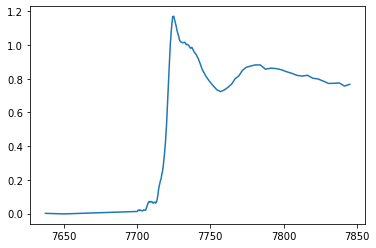

In [15]:
fig, ax = plt.subplots()
ax.plot(energies_norm, Ir_norm[:,0])
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
# ax.set_xticklabels(['a','a','a'])  # xticks(np.arange(7700, 7800, step=10))

In [16]:
def plotXANES(energies, Irs, Etas, start_eta=0, stop_eta=0, marker='.', inset_dict={},
             startE=7705, stopE=7730, size=(9, 6)):
    def format_func(value, tick_number):
        return f'{value:.1f}'

    if not inset_dict:
        inset_dict = {'start_energy':7718, 'stop_energy':7720, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.1, 'y1_adj': 0,
                      'y2_adj': 0, 'y_interval': 0.02, 'x_lateral': 0,
                      'y_vertical':0}
    
    x1_adj = inset_dict['x1_adj']
    x2_adj = inset_dict['x2_adj']
    x_interval = inset_dict['x_interval']
    y1_adj = inset_dict['y1_adj']
    y2_adj = inset_dict['y2_adj']
    y_interval = inset_dict['y_interval']
    x_lat = inset_dict['x_lateral']
    y_vert = inset_dict['y_vertical']

    title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal'}
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['legend.fontsize'] = 16
    mpl.rcParams['axes.labelsize'] = 16


    # Finding max and min of Ir across all data sets for setting plot limits
    Ir_abs_max = np.max(Irs)
    Ir_abs_min = np.round(np.min(Ir_norm[np.argwhere(energies>=startE)[0][0], :]), 2)

    # Finding max and min of eta (or voltage) for setting color bar limits
    max_eta = int(round(np.max(Etas) * 1000, 0))
    min_eta = int(round(np.min(Etas) * 1000, 0))

    ## Plotting full XANES spectra
    fig = plt.figure(constrained_layout=False, figsize=size)
    gs = fig.add_gridspec(7, 25)
    f_ax1 = fig.add_subplot(gs[:, :-1])

    for n in range(start_eta, Irs.shape[-1] - stop_eta):
        f_ax1.plot(energies, Irs[:, n], color=colorfun(Etas[n], np.max(np.abs(Etas))),
                 linestyle='-',linewidth=.3, marker='', markersize=3,
                   label=f'{Etas[n]} mV')

    f_ax1.set(xlim=[startE,stopE], ylim=[.97 * Ir_abs_min, 1.05 * Ir_abs_max])
    f_ax1.set_ylabel(r'Absorption  / a.u.', **title_font)
    f_ax1.set_xlabel(r'Energy  /  eV', **title_font)

    ## Plotting XANES inset
    f_ax2=fig.add_subplot(gs[0:4,3:13])    
    for n in range(start_eta, Irs.shape[-1] - stop_eta):
        f_ax2.plot(energies, Irs[:, n], color=colorfun(Etas[n], np.max(np.abs(Etas))),
                 linestyle='-',linewidth=1, marker=marker, markersize=3,
                   label=f'{Etas[n]} mV')

    ## Choosing plot limits for inset
    xind1=np.argwhere(energies>=inset_dict['start_energy'])[0]
    xind2=np.argwhere(energies<=inset_dict['stop_energy'])[-1]

    x1=round(energies[xind1][0])
    x2=round(energies[xind2][0])

    y1=round(Irs[xind1,0][0]*.95,2)
    y2=round(Irs[xind2,0][0]*1.05,2)

    f_ax2.set(xlim=[x1+x_lat+x1_adj, x2+x_lat+x2_adj], 
          xticks=np.arange(x1+x1_adj, x2+x2_adj, x_interval),
          ylim=[y1+y_vert+y1_adj, y2+y_vert+y2_adj], 
          yticks=np.arange(y1+y1_adj, y2+y2_adj,y_interval))

    f_ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
    f_ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    f_ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))


    # Plotting colorbar
    f_ax3=fig.add_subplot(gs[:5,-1])
    cdict = {'red':   [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 1.0, 1.0)],

                     'green': [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],

                     'blue':  [(0.0, 1.0, 1.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],}

    cmap_name = 'my_list'
    cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
    norm = mpl.colors.Normalize(vmin=min_eta, vmax=max_eta)
    cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm, norm=norm, orientation='vertical')
    cb1.set_ticks([min_eta, 0, max_eta])
    cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')
    
    return fig

In [17]:
np.shape(Ir_norm)

(176, 40)

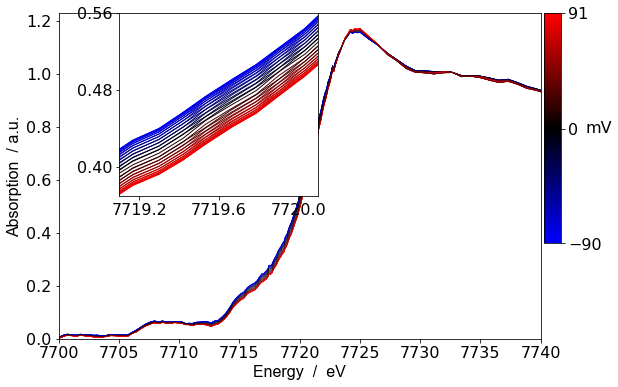

In [18]:
inset_dict = {'start_energy':7719, 'stop_energy':7720.5, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.5, 'y1_adj': 0,
                      'y2_adj': -0.05, 'y_interval': 0.06, 'x_lateral': 0.1, 'y_vertical':0}
fig = plotXANES(energies_norm, Ir_norm[:,1:], Eta_norm[1:], startE=7700,stopE=7740,
               inset_dict=inset_dict, size=(9,6), marker='')
# plt.savefig(r'Plots\\0.5 Hz XANES Spectra.png', bbox_inches='tight', dpi=400)

(-0.05168025445675005, 0.014510811088712766)

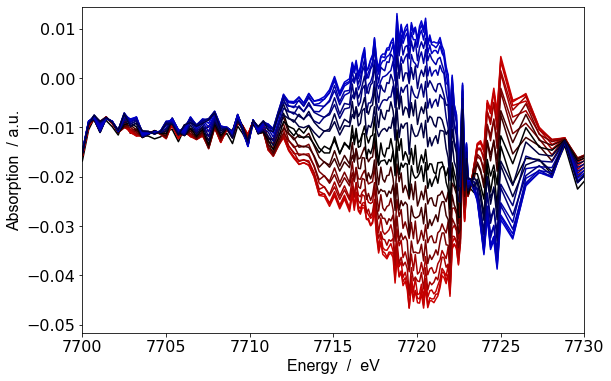

In [19]:
# Difference plot using unnormalized Ir
fig = plt.figure(constrained_layout=False, figsize=(9,6))
gs = fig.add_gridspec(7, 25)
ax1 = fig.add_subplot(gs[:, :])
max_eta = int(round(np.max(-Etas[0,:].real) * 1000, 0))
min_eta = int(round(np.min(-Etas[0,:].real) * 1000, 0))

for n, Ir in enumerate(Irs[:,1::100].T.real):
    ax1.plot(energies,Ir, color=colorfun(Etas[0,n*100].real, np.max(np.abs(Etas))))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal'}
ax1.set_ylabel(r'Absorption  / a.u.', **title_font)
ax1.set_xlabel(r'Energy  /  eV', **title_font)  
# # Plotting colorbar
# f_ax3=fig.add_subplot(gs[:5,-1])
# cdict = {'red':   [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 1.0, 1.0)],

#                  'green': [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],

#                  'blue':  [(0.0, 1.0, 1.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],}

# cmap_name = 'my_list'
# cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
# norm = mpl.colors.Normalize(vmin=min_eta, vmax=max_eta)
# cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm, norm=norm, orientation='vertical')
# cb1.set_ticks([min_eta, 0, max_eta])
# cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')

xind1 = np.argwhere(energies>=7700)[0][0]
xind2 = np.argwhere(energies<=7730)[-1][0]

ylim1 = np.min(Irs[xind1:xind2,:].real)
ylim2 = np.max(Irs[xind1:xind2,:].real)
ax1.set_xlim(7700, 7730)
ax1.set_ylim(ylim1*1.1, ylim2*1.1)

# plt.savefig(r'Plots\\0.5 Hz XANES Differences.png', bbox_inches='tight', dpi=400)

In [20]:
Eta_norm[20]

0.0002327352203776173

(7700.0, 7740.0)

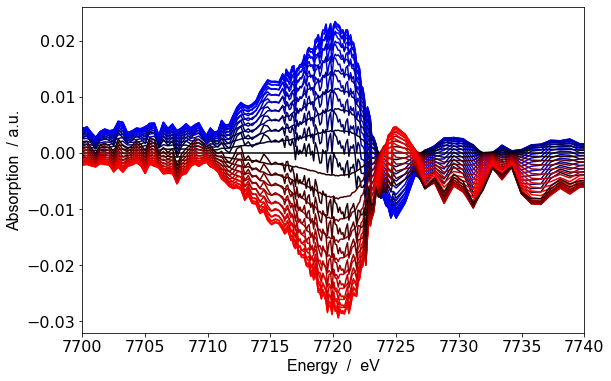

In [21]:
# Difference plot using normalized Ir
# Using Eta_norm[20] as OCV even though it's actually for +0.2 mV, since 
# Eta_norm[0] is making it look weird...

fig = plt.figure(constrained_layout=False, figsize=(9,6))
gs = fig.add_gridspec(7, 25)
ax1 = fig.add_subplot(gs[:, :])
max_eta = int(round(np.max(-Etas[0,:].real) * 1000, 0))
min_eta = int(round(np.min(-Etas[0,:].real) * 1000, 0))

for n, Ir in enumerate(Ir_norm[:,1:].T):
    ax1.plot(energies_norm, Ir - Ir_norm[:,20], color=colorfun(Eta_norm[n+1], np.max(np.abs(Eta_norm))))# color=colorfun(-Etas[0,n*100].real, np.max(np.abs(-Etas))))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal'}
ax1.set_ylabel(r'Absorption  / a.u.', **title_font)
ax1.set_xlabel(r'Energy  /  eV', **title_font)  
# # Plotting colorbar
# f_ax3=fig.add_subplot(gs[:5,-1])
# cdict = {'red':   [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 1.0, 1.0)],

#                  'green': [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],

#                  'blue':  [(0.0, 1.0, 1.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],}

# cmap_name = 'my_list'
# cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
# norm = mpl.colors.Normalize(vmin=min_eta, vmax=max_eta)
# cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm, norm=norm, orientation='vertical')
# cb1.set_ticks([min_eta, 0, max_eta])
# cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')

xind1 = np.argwhere(energies>=7700)[0][0]
xind2 = np.argwhere(energies<=7730)[-1][0]

ylim1 = np.min(Irs[xind1:xind2,:].real)
ylim2 = np.max(Irs[xind1:xind2,:].real)
ax1.set_xlim(7700, 7740)
# ax1.set_ylim(ylim1*1.1, ylim2*1.1)

# plt.savefig(r'Plots\\0.5 Hz XANES Differences.png', bbox_inches='tight', dpi=400)